In [12]:
import os
import mne
import numpy as np
import sys
import pandas as pd
import logging
from enum import Enum
from typing import Optional, Generator
from collections import namedtuple
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt
# from deepmeg.utils.params import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.preprocessing import BasicPreprocessor
from utils.storage import DLStorageIterator, STAGE
from deepmeg.utils.viz import InterpretationPlotter, plot_patterns
from deepmeg.preprocessing.transforms import one_hot_decoder
from deepmeg.utils.colors import generate_cmap

from deepmeg.utils.convtools import conviter
from deepmeg.utils.params import LFCNNParameters, read_pkl

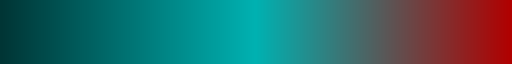

In [13]:
cmap = generate_cmap(
    '#003535',
    '#00b2b2',
    '#b20000'
)
cmap

In [14]:
p1 = read_pkl('/data/pt_02648/spatual/RESULTS/sbj02/action_lfcnn/params.pkl')
p2 = read_pkl('/data/pt_02648/spatual/RESULTS/sbj03/action_lfcnn/params.pkl')

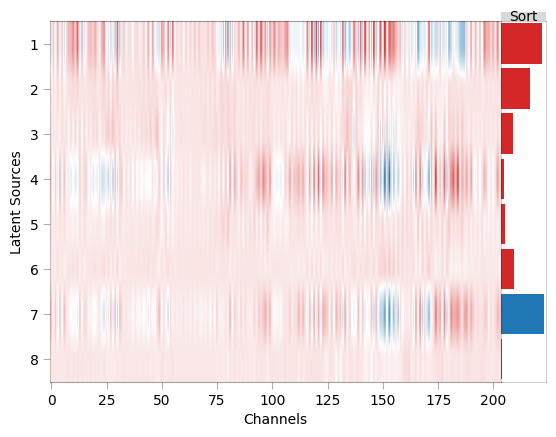

In [7]:
%matplotlib qt
InterpretationPlotter(p1).plot()

In [ ]:
p1.__dict__

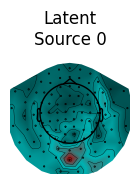

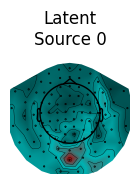

In [16]:
plot_patterns(
    p1.spatial.patterns,
    p1.info,
    p1.order[0],
    cmap=cmap
)

In [4]:

patterns = list()
for subject_num in range(1, 31):
    subject_name = f'sbj{subject_num :02}'
    path = f'/data/pt_02648/spatual/RESULTS/{subject_name}/action_lfcnn/params.pkl'
    if os.path.exists(path):
        patterns.append(read_pkl(path).spatial.patterns)

patterns = np.array(patterns)

In [5]:
patterns.shape

(27, 204, 8)

In [6]:
patterns_t = np.transpose(patterns, (1, 0, 2))

In [8]:
patterns_t = np.reshape(patterns_t, (patterns_t.shape[0], -1))

In [9]:
patterns_t.shape

(204, 216)

In [38]:
from sklearn.cluster import KMeans

#Initialize the class object
kmeans = KMeans(n_clusters= 8)

pr = kmeans.fit_predict(np.corrcoef(patterns_t.T))

/data/pt_02648/NeuralGeometry/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


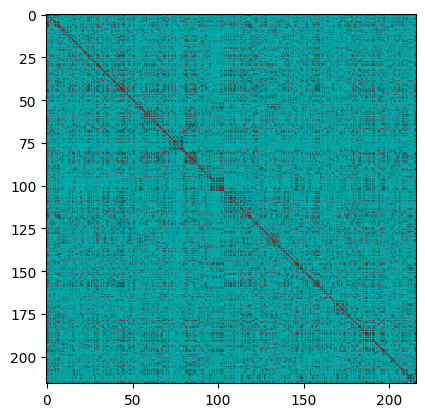

In [67]:
plt.imshow(np.corrcoef(patterns_t.T), cmap=cmap)

In [73]:
M = np.corrcoef(patterns_t.T)

In [76]:
pr

array([6, 6, 5, 4, 5, 7, 6, 6, 0, 1, 1, 0, 1, 3, 0, 4, 7, 2, 0, 3, 4, 0,
       4, 7, 3, 3, 4, 0, 4, 6, 6, 2, 1, 3, 1, 4, 4, 0, 1, 3, 2, 7, 4, 4,
       4, 4, 7, 3, 4, 5, 2, 4, 2, 0, 1, 3, 0, 5, 4, 7, 6, 7, 6, 7, 6, 3,
       1, 6, 3, 3, 7, 3, 1, 4, 1, 4, 5, 1, 5, 5, 5, 3, 6, 7, 7, 0, 7, 3,
       4, 5, 2, 6, 5, 4, 5, 0, 6, 7, 6, 7, 6, 7, 7, 5, 3, 4, 3, 4, 4, 6,
       3, 2, 3, 4, 4, 3, 6, 5, 4, 4, 3, 4, 5, 5, 1, 6, 2, 0, 6, 1, 2, 0,
       2, 0, 0, 1, 2, 4, 3, 3, 1, 4, 5, 7, 3, 2, 6, 0, 2, 7, 2, 0, 4, 2,
       6, 7, 4, 3, 0, 3, 2, 4, 6, 1, 2, 5, 1, 3, 7, 2, 2, 6, 4, 2, 5, 0,
       6, 5, 1, 7, 6, 5, 3, 3, 0, 7, 6, 6, 7, 6, 7, 7, 0, 0, 3, 6, 6, 6,
       0, 3, 0, 5, 6, 4, 7, 6, 4, 6, 6, 7, 6, 2, 0, 0, 2, 7], dtype=int32)

In [92]:
def get_cluster_map(preds, n_cluster):
    out = np.zeros((len(preds), len(preds)))
    for i, pred1 in enumerate(preds):
        for j, pred2 in enumerate(preds):
            if pred1 == n_cluster and pred2 == n_cluster:
                out[i, j] = 1
    return out

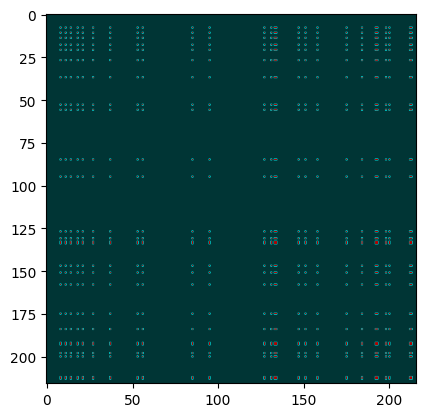

In [96]:
mqp1 = get_cluster_map(pr, 0)

plt.imshow(mqp1, cmap=cmap)

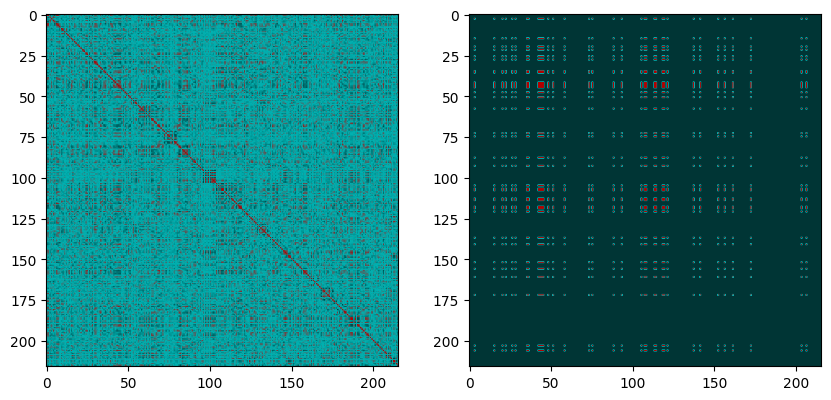

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(M, cmap=cmap)
ax2.imshow(get_cluster_map(pr, 4), cmap=cmap)

In [88]:
np.corrcoef(np.reshape(np.transpose(p1.temporal.time_courses, (1, 0, 2)), (8, -1)))

array([[ 1.        ,  0.03957347, -0.18788142, -0.03784432, -0.08607408,
         0.26327952,  0.43865248, -0.30159061],
       [ 0.03957347,  1.        ,  0.11931129,  0.01845955, -0.06353562,
         0.08333155,  0.17461168, -0.21889017],
       [-0.18788142,  0.11931129,  1.        ,  0.02833744,  0.02277816,
         0.00930394,  0.16386831, -0.15383369],
       [-0.03784432,  0.01845955,  0.02833744,  1.        ,  0.02448259,
        -0.059725  , -0.20295368,  0.23777207],
       [-0.08607408, -0.06353562,  0.02277816,  0.02448259,  1.        ,
         0.16277863,  0.01338741, -0.30450211],
       [ 0.26327952,  0.08333155,  0.00930394, -0.059725  ,  0.16277863,
         1.        ,  0.20490527, -0.35019714],
       [ 0.43865248,  0.17461168,  0.16386831, -0.20295368,  0.01338741,
         0.20490527,  1.        , -0.37833393],
       [-0.30159061, -0.21889017, -0.15383369,  0.23777207, -0.30450211,
        -0.35019714, -0.37833393,  1.        ]])

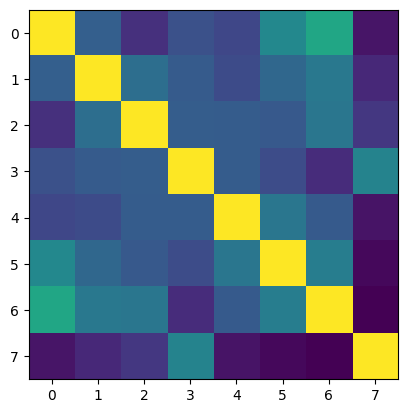

In [91]:
plt.imshow(np.corrcoef(np.reshape(np.transpose(p1.temporal.time_courses, (1, 0, 2)), (8, -1))))

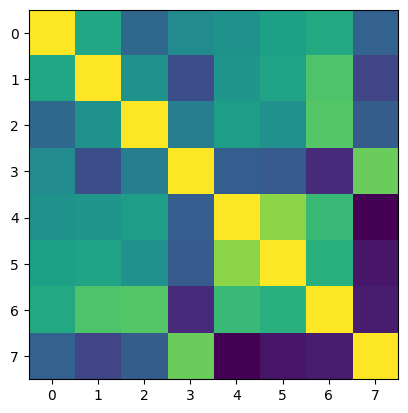

In [90]:
plt.imshow(np.corrcoef(p1.spatial.patterns.T))

In [43]:
clusters = [
    patterns_t[:, pr == i]
    for i in range(8)
]

In [45]:
for cluster in clusters:
    print(cluster.shape)

(204, 26)
(204, 18)
(204, 22)
(204, 30)
(204, 35)
(204, 21)
(204, 36)
(204, 28)


In [59]:
clusters[0].shape

(204, 26)

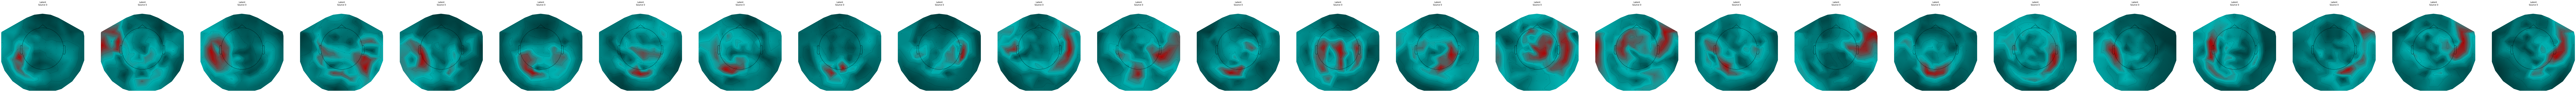

In [66]:
%matplotlib inline

from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, len(clusters[0].T), figsize=(len(clusters[0].T)*10, 10))

for cluster, ax in zip(clusters[0].T, axes):
    component = np.expand_dims(cluster, 1)
    _ = plot_patterns(
        component,
        p1.info,
        0,
        axes=ax,
        cmap=cmap,
        show = False
    )

plt.show()

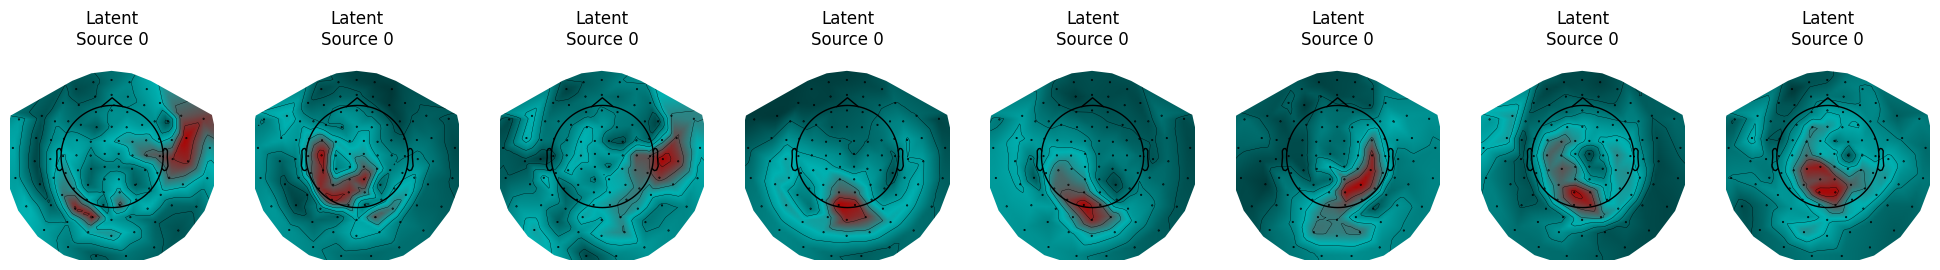

In [55]:
%matplotlib inline

from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, len(clusters), figsize=(len(clusters)*3, 1*3))

for cluster, ax in zip(clusters, axes):
    component = np.expand_dims(cluster.mean(1), 1)
    _ = plot_patterns(
        component,
        p1.info,
        0,
        axes=ax,
        cmap=cmap,
        show = False
    )

plt.show()

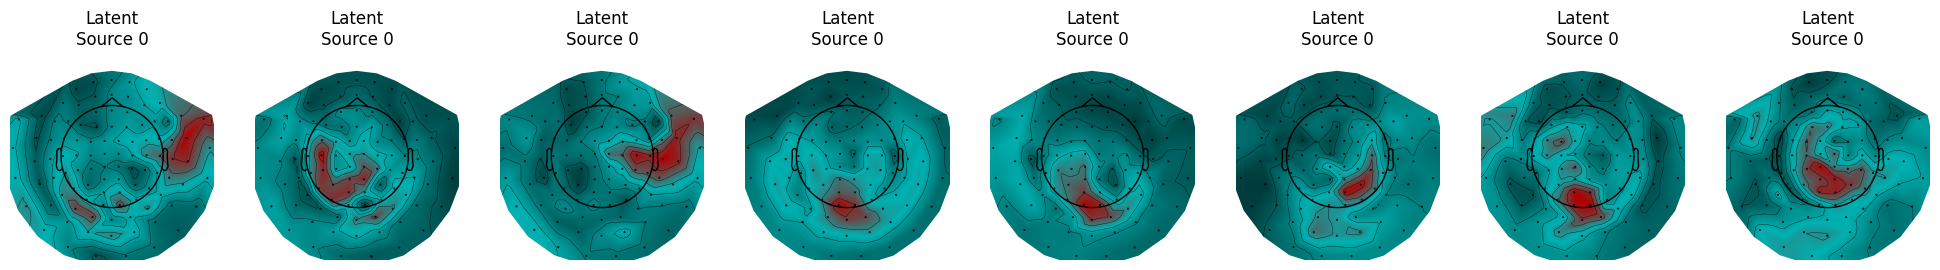

In [54]:
%matplotlib inline

from sklearn.decomposition import PCA

pca = PCA(n_components=1)

fig, axes = plt.subplots(1, len(clusters), figsize=(len(clusters)*3, 1*3))

for cluster, ax in zip(clusters, axes):
    component = pca.fit_transform(cluster)
    _ = plot_patterns(
        component,
        p1.info,
        0,
        axes=ax,
        cmap=cmap,
        show = False
    )

plt.show()